### Code implemented when analysing individual example and producing disc models

requires downloading any galaxy fits file using the `wget` function in the terminal followed by the fits file link. For applying the analysis here, the files were compiled into corresponding band fits folders.

Portions of the code were developed with the assistance of AI-based programming tools (e.g. Copilot, ChatGPT). All generated code was reviewed, tested, and validated by the authors to ensure scientific accuracy and correctness.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from astropy.io import fits
from scipy.stats import linregress
from astropy.wcs import WCS
from scipy.optimize import root_scalar
from flex import FLEX
from astropy.visualization import make_lupton_rgb

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file

from src.discmodel import DiscGalaxy


"""Initialise Galaxy Model Parameters"""
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 212.
nbins = 64
mmax = 10
nmax = 10
noise = 0.5

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

ModuleNotFoundError: No module named 'src.discmodel'

Portions of the code were developed with the assistance of AI-based programming tools (e.g. Copilot, ChatGPT). All generated code was reviewed, tested, and validated by the authors to ensure scientific accuracy and correctness.


In [4]:
# requires: from flex import FLEX

def galaxymorphology(file_or_array, galaxy=None, data=None, noisefloor=-5.0):
    """
    Compute inclination and position angle from a galaxy image.

    Parameters
    ----------
    file_or_array : str | np.ndarray
        Either a FITS filename (string path) or a 2D NumPy array image.
        If FITS: image is read from HDU[1] if present, else HDU[0].
    galaxy : str, optional
        Galaxy name (used only if 'data' with RA/DEC is provided).
    data : pandas.DataFrame or dict-like, optional
        Must contain RA/DEC columns (e.g. 'RA_LEDA', 'DEC_LEDA') and 'GALAXY'.
        If provided (with galaxy), recenters using WCS pixel coordinates.
    noisefloor : float, default -5.0
        Log-intensity threshold for outer radius selection.

    Returns
    -------
    inc_bt : float
        Estimated inclination (degrees).
    PA : float
        Estimated position angle (degrees, astronomical convention).
    galaxy_name : str
        Galaxy identifier (or "synthetic" for arrays).
    a : float
        Scale parameter used for FLEX (1.5 * exponential scale length).
    eta_bt : float
        Bulge-to-total-like estimator from m=2 amplitude ratio.
    maxrad : float
        Outer radius (pixels) determined by noise floor.
    radius : float
        Working aperture radius (pixels) used for initial masking.
    """
    # Helper Functions
    def cos_plus_exp(x_deg, A, B, D,C, E, F):
        x_rad = np.deg2rad(x_deg)
        return A * np.cos(B * x_rad+C) + D + E * np.exp(F * x_deg)

    def find_inclination_from_eta(eta_target, A, B, D, C, E, F,
                                  search_range=(0, 90), tol=1e-6, verbose=False):
        def f(x):
            return cos_plus_exp(x, A, B, C,D, E, F) - eta_target

        x_min, x_max = search_range
        fmin, fmax = f(x_min), f(x_max)
        if np.sign(fmin) == np.sign(fmax):
            if verbose:
                print("Eta target is outside model range, extrapolating.")
            x_grid = np.linspace(x_min, x_max, 2000)
            return x_grid[np.argmin(np.abs(f(x_grid)))]

        sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
        if not sol.converged:
            raise RuntimeError("Root finding failed to converge.")
        return sol.root

    # array or FITS file input
    if isinstance(file_or_array, np.ndarray):
        image_data = np.asarray(file_or_array, dtype=float)
        header = None
        wcs = None
        galaxy_name = "synthetic"
    else:
        # FITS path
        with fits.open(file_or_array) as hdulist:
            if len(hdulist) > 1 and hdulist[1].data is not None:
                image_data = np.asarray(hdulist[1].data, dtype=float)
                header = hdulist[1].header
            else:
                image_data = np.asarray(hdulist[0].data, dtype=float)
                header = hdulist[0].header
        galaxy_name = str(file_or_array).split("-")[0]
        try:
            wcs = WCS(header)
        except Exception:
            wcs = None

    # Geometric setup
    if image_data.ndim != 2:
        raise ValueError("Input image must be a 2D array.")

    h, w = image_data.shape
    y, x = np.indices((h, w))  # y=row, x=col

    # Working aperture (adjustable hyperparameter)
    radius = h // 4

    # Centering: WCS if galaxy/data provided; else image center
    if (data is not None) and (galaxy is not None) and (wcs is not None):
        ra = data['RA_LEDA'][data['GALAXY'] == galaxy]
        dec = data['DEC_LEDA'][data['GALAXY'] == galaxy]
        pix = wcs.world_to_pixel_values(ra, dec)
        cx, cy = float(pix[0]), float(pix[1])
    else:
        cx, cy = (w // 2), (h // 2)

    # Shifted coordinates (X along columns, Y along rows)
    X = x - cx
    Y = y - cy
    R = np.sqrt(X**2 + Y**2)

    # Masked working image
    mask = R <= radius
    work = np.where(mask, image_data, 0.0)

    # Intensity vs radius data for scale length fit
    I = image_data.ravel()  # use original for slope, but restrict by radius later
    R_flat = R.ravel()
    valid0 = (I > 0) & (R_flat <= radius)
    R_valid = R_flat[valid0]
    I_valid = I[valid0]

    # Sort by radius
    rindx = R_valid.argsort()
    R_sorted = R_valid[rindx]
    I_sorted = I_valid[rindx]

    # Moving average for noise floor detection
    window = min(100, max(5, len(R_sorted)//50))  # adaptive, keeps it robust
    if window % 2 == 0:
        window += 1
    if len(R_sorted) < window:
        window = max(5, len(R_sorted))

    if window <= 1:
        means_R = R_sorted
        means_I = I_sorted
    else:
        kern = np.ones(window) / window
        means_R = np.convolve(R_sorted, kern, mode='valid')
        means_I = np.convolve(I_sorted, kern, mode='valid')

    # Determine outer radius by noise floor in log-space
    I_clip = np.clip(means_I, 1e-12, None)
    below = np.where(np.log(I_clip) < noisefloor)[0]
    maxrad = float(means_R[below[0]]) if len(below) > 0 else float(means_R[-1])

    # Fit exponential scale length within maxrad
    sel = (R_flat <= maxrad) & (image_data.ravel() > 0)
    R_fit = R_flat[sel]
    lnI_fit = np.log(np.clip(image_data.ravel()[sel], 1e-12, None))

    if len(R_fit) < 10:
        # Fallback if too few points
        scale_length = 30.0
    else:
        slope, intercept, *_ = linregress(R_fit, lnI_fit)
        scale_length = -1.0 / slope if slope != 0 else 30.0
        # Fix to plausible range
        if scale_length < 0:
            scale_length = 50.0
        if scale_length > 100:
            scale_length = 30.0

    a = 1.5 * float(scale_length)

    # FLEX expansion
    mmax, nmax = 6, 10
    # R, P in polar coordinates over entire image (not only masked)
    P = np.arctan2(Y, X)

    L = FLEX(a, mmax, nmax, R.ravel(), P.ravel(), mass=image_data.ravel())
    c1, s1 = L.coscoefs, L.sincoefs  # shapes: (mmax+1, nmax+1) each

    # m=2 amplitude normalized by m=0 gives eta metric
    num = np.linalg.norm(np.sqrt(c1[2]**2 + s1[2]**2))
    den = np.linalg.norm(c1[0])

    eta_bt = num / den 
    # suggested inversion relation parameters
    if h in [0,64]:
        A_fit=-1.49622942e-01
        B_fit=-3.25013042  
        C_fit=8.82095893
        D_fit=-9.99999753e-01
        E_fit=1.01878444 
        F_fit=7.78671084e-03
    if h in [65,128]:
        A_fit=-0.28589325 
        B_fit=-1.9746376   
        C_fit=8.50704234 
        D_fit=-0.92001011  
        E_fit=0.89375603  
        F_fit=0.01039217
    if h in [129,256]:
        A_fit=-0.24444315 
        B_fit=-2.27534356  
        C_fit=8.59288841 
        D_fit=-0.99999985  
        E_fit=0.94045508  
        F_fit=0.00969384
        
        
    if h >256:
        A_fit=-0.24293078 
        B_fit=-2.27490232  
        C_fit=8.59360551 
        D_fit=-0.99999984  
        E_fit=0.93814061  
        F_fit=0.00971964
    
        
    inc_bt = float(find_inclination_from_eta(eta_bt, A_fit, B_fit, C_fit, D_fit, E_fit, F_fit, verbose=False))

    # Position angle calculation
    phi = np.arctan2(s1[2, 0], c1[2, 0])  # radians

    # Position angle in astronomical convention
    PA = 90 + (np.degrees(phi)) / 2.0

    return float(inc_bt), float(PA), str(galaxy_name), float(a), float(eta_bt), float(maxrad), float(radius), float(h)


In [5]:
# How to run for particular files

Name=[]
Inc=[]
PA=[]
eta=[]
size=[]
fits_files = glob.glob('data/gfits3/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    eta.append(A[4])
    size
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}, a={A[3]:.4f}, h={A[7]:.0f}")

Processed data/gfits3/NGC5289: Inc=52.32, PA=98.94, a=55.9271, h=1605
Processed data/gfits3/NGC6186: Inc=56.92, PA=57.68, a=66.1754, h=1079
Processed data/gfits3/NGC3310: Inc=20.97, PA=5.17, a=91.1223, h=2125
Processed data/gfits3/NGC2893: Inc=33.78, PA=158.48, a=43.2168, h=699
Processed data/gfits3/NGC2776: Inc=45.10, PA=129.29, a=106.8950, h=2075
Processed data/gfits3/NGC4203: Inc=84.06, PA=4.49, a=134.3193, h=3069
Processed data/gfits3/NGC5676: Inc=62.47, PA=42.03, a=86.2922, h=2467
Processed data/gfits3/NGC4369: Inc=58.06, PA=147.60, a=90.5230, h=1363
Processed data/gfits3/NGC4100: Inc=88.41, PA=163.74, a=114.0925, h=3135
Processed data/gfits3/NGC5112: Inc=64.16, PA=126.97, a=137.7649, h=2057
Processed data/gfits3/NGC3726: Inc=56.75, PA=21.88, a=45.0000, h=3883
Processed data/gfits3/NGC4359: Inc=76.21, PA=109.76, a=78.9315, h=949
Processed data/gfits3/NGC3556: Inc=82.20, PA=79.66, a=45.0000, h=5985
Processed data/gfits3/NGC6217: Inc=40.55, PA=151.39, a=93.6199, h=1539
Processed dat

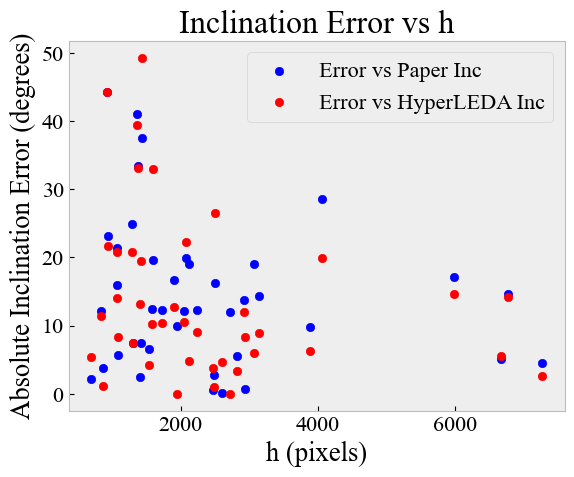

0.5960370670664179


In [ ]:
Inc = [
45.1, 54.31, 33.78, 38.82, 68.47, 70.5, 34.5, 71.4, 20.97, 74.68,
48.8, 33.29, 48.45, 59.38, 84.76, 23.37, 82.2, 56.75, 39.28, 68.55,
88.41, 81.71, 84.06, 76.21, 58.06, 42.83, 67.46, 39.84, 50.38, 64.16,
52.32, 90.0, 50.73, 62.47, 90.0, 68.04, 81.49, 56.92, 40.55, 64.17, 80.96
]
h = [
2075, 2235, 699, 2483, 1413, 1429, 2825, 1583, 2125, 2931,
1313, 923, 1073, 1387, 1911, 1093, 5985, 3883, 1731, 4055,
3135, 2945, 3069, 949, 1363, 875, 7261, 6669, 6761, 2057,
1605, 2723, 2501, 2467, 1951, 2607, 1437, 1079, 1539, 847, 1293
]
Paper_inc = [
65, 42, 36, 36, 71, 78, 29, 59, 40, 61,
56.3, 77.6, 27, 26, 68, 29, 65, 47, 27, 40,
74, 81, 65, 53, 17, 39, 63, 45, 65, 52,
72, 78, 67, 63, 80, 68, 44, 41, 34, 52, 56
]

HyperLEDA_inc = [
67.4, 45.2, 39.1, 37.9, 81.6, 90.0, 31.2, 61.1, 16.1, 62.7,
56.3, 77.6, 27.7, 26.3, 72.1, 31.7, 67.5, 50.5, 28.9, 48.7,
79.5, 90.0, 90.0, 54.5, 18.6, 41.7, 64.8, 45.4, 64.6, 53.6,
85.3, 90.0, 77.2, 66.2, 90.0, 72.7, 32.2, 71.0, 44.8, 52.7, 60.1
]


Error_paper = np.abs(np.array(Inc)-np.array(Paper_inc))
Error_HyperLEDA = np.abs(np.array(Inc)-np.array(HyperLEDA_inc))

plt.scatter(h, Error_paper, label='Error vs Paper Inc', color='blue')
plt.scatter(h, Error_HyperLEDA, label='Error vs HyperLEDA Inc', color='red')
plt.xlabel('h (pixels)')
plt.ylabel('Absolute Inclination Error (degrees)')
plt.title('Inclination Error vs h')
plt.legend()
plt.grid()
plt.show()

Processed data/gfits3/NGC3067: Inc=68.47, PA=103.83, eta=0.60
1413 1413


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/astropy/visualization/lupton_rgb.py:645: RuntimeWarning: invalid value encountered in divide
  fInorm = np.where(Int <= 0, 0, np.true_divide(fI, Int))


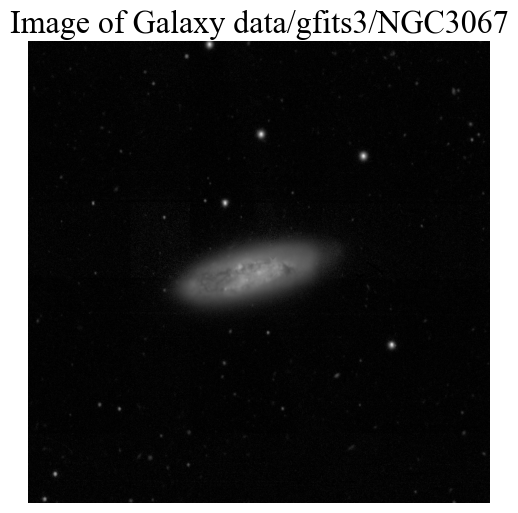

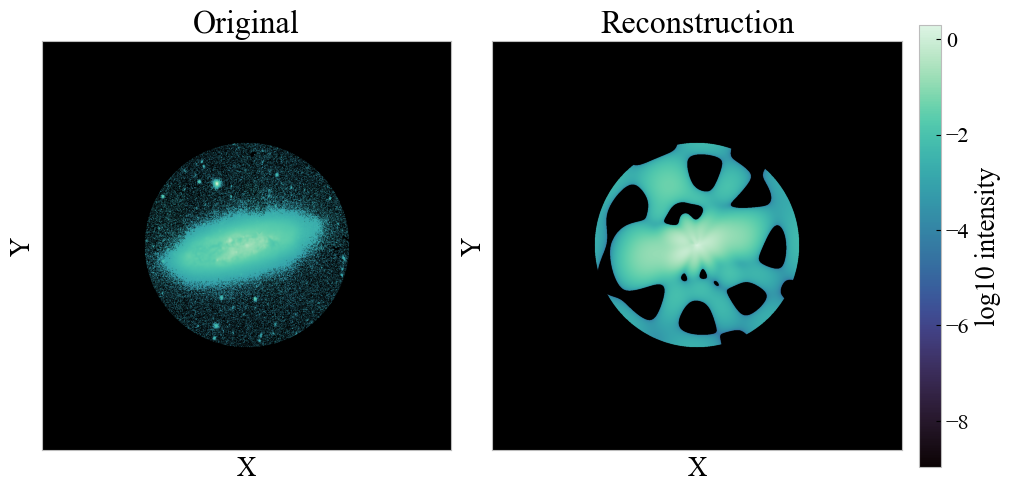

34.461687704933595


In [14]:
file=fits_files[36] #picking particular file for detailed plotting

A=galaxymorphology(file)
Name.append(A[2])
Inc.append(A[0])
PA.append(A[1])
eta.append(A[4])

print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}, eta={A[4]:.2f}")

with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
galaxy_name = file.split("-")[0]
h, w = image_data.shape
print(h,w)
#process the same as within morphology function
gray=image_data.copy() 
rmaxx = h // 2
rmaxy = w // 2
nbins=h
radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')

R = np.sqrt(X2**2 + Y2**2).ravel()
I = image_data.ravel()
rgb_image = make_lupton_rgb(image_data, image_data, image_data, stretch=0.1, Q=10)
# Filter for positive intensities and R <= 80
valid = (I > 0) & (R <= 80)
R_valid = R[valid]
logI_valid = np.log(I[valid])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
scale_length = -1 / slope
if scale_length < 0:
    scale_length = 50
if scale_length > 100:
    scale_length = 30

a=scale_length*1.5


x_edges = np.asarray(x_edges).ravel()
y_edges = np.asarray(y_edges).ravel()

if x_edges.size < 2 or y_edges.size < 2:
    raise ValueError("Need at least two edges along each axis.")

# If reversed (common for image-style Y axes), flip them:
if x_edges[0] > x_edges[-1]:
    x_edges = x_edges[::-1]
if y_edges[0] > y_edges[-1]:
    y_edges = y_edges[::-1]

# If they’re not strictly increasing (duplicates), uniquify & sort:
x_edges = np.unique(x_edges)
y_edges = np.unique(y_edges)
D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
D.img       = gray  
D.x_edges   = x_edges
D.y_edges   = y_edges
D.x_centers = x_centers
D.y_centers = y_centers

mmax, nmax = 8, 10
E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)

img_orig = D.img.copy()



# FLEX reconstruction
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)   

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = X2.ravel()
y_flat = Y2.ravel()
w_flat = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)

# avoid divide-by-zero; normalize total flux to the original image
recon_img = recon_img / np.maximum(counts, 1)
# match total intensity
total_recon = np.sum(recon_img)
if total_recon > 0:
    recon_img *= np.sum(img_orig) / total_recon

recon_img = recon_img.T.T  # to match imshow orientation
plt.figure(figsize=(6,6))
plt.imshow(rgb_image, origin='lower')
plt.title(f"Image of Galaxy {galaxy_name}")
plt.axis('off')
plt.show()

#Side-by-side plots of original and reconstruction with log scale intensity filtering
cmap = sns.color_palette("mako", as_cmap=True)
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
recon_img = np.where(mask*1.2, recon_img, 0.0)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))
x_edges = np.linspace(-rmaxx, rmaxx, nbins + 1)
y_edges = np.linspace(-rmaxy, rmaxy, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
N=1000000


origdisc_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
fig1, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for ax, im, title in zip(axes, [orig_log, recon_log], ["Original", "Reconstruction"]):
    h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
    ax.set_title(title)
    ax.set(facecolor="black")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar = fig1.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label("log10 intensity")

plt.show()
print(scale_length)


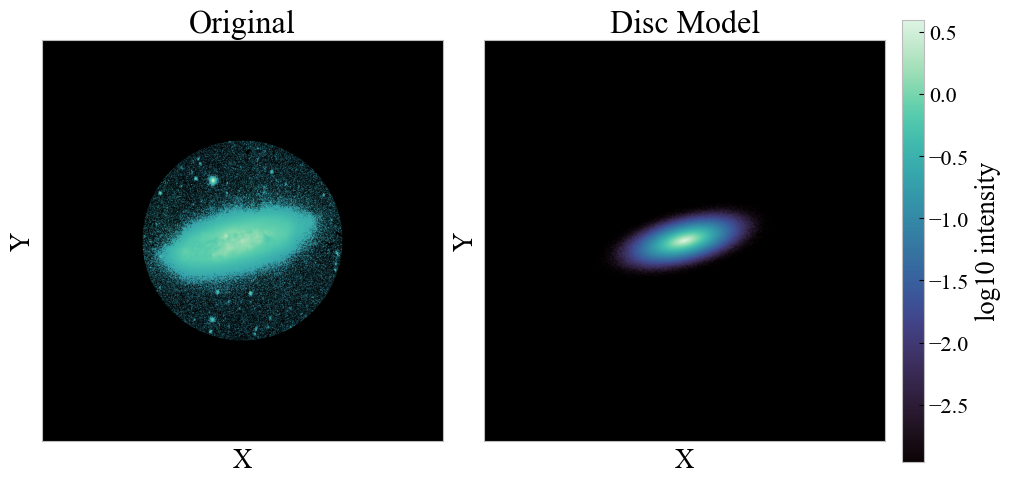

In [15]:
#Recreating disc model image for comparison

N=10000000
D = DiscGalaxy(N=N, a=scale_length, M=np.sum(gray))  

# Rotate and generate the image with recovered orientation
D.rotate_disc(float(A[0]), 0,90+float(A[1])) 
D.generate_image(rmax=rmaxx, nbins=nbins, noiselevel=noise)
img_new_orig = D.img.copy()

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
r_flat = D.r.ravel()
p_flat = D.p.ravel()


x_flat = r_flat * np.cos(p_flat)
y_flat = r_flat * np.sin(p_flat)


counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)




origdisc_log = np.log10(np.where(img_new_orig > 0, img_new_orig, np.nan))
fig1, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

#plot side by side
for ax, im, title in zip(axes, [orig_log, origdisc_log], ["Original", "Disc Model"]):
    h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
    ax.set_title(title)
    ax.set(facecolor="black")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar = fig1.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label("log10 intensity")


plt.show()

In [ ]:
from PIL import Image
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
# Load JPEG and convert to float array
jpeg_img = Image.open("NGC3067-largegalaxy-image-grz.jpg").convert("RGB")
rgb_image = np.array(jpeg_img) / 255.0  # normalize to 0–1
rgb_image = np.flipud(rgb_image)  # flips along vertical axis

# --- Create combined 2x2 comparison grid ---

fig, axes = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)
cmap = sns.color_palette("mako", as_cmap=True)
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]


axes[0, 0].imshow(rgb_image, origin='lower')
axes[0, 0].set_title(f"NGC3067 Image")
axes[0, 0].axis('off')

# 2️⃣ Original FITS (log intensity)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
im1 = axes[0, 1].imshow(orig_log, extent=extent, cmap=cmap, origin="lower")
axes[0, 1].set_title("Masked Original FITS Image")
axes[0, 1].set_xticks([]); axes[0, 1].set_yticks([])
axes[0, 1].set(facecolor="black")

# 3️⃣ FLEX reconstruction
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))
im2 = axes[1, 0].imshow(recon_log, extent=extent, cmap=cmap, origin="lower")
axes[1, 0].set_title("FLEX Reconstruction")
axes[1, 0].set_xticks([]); axes[1, 0].set_yticks([])
axes[1, 0].set(facecolor="black")

# 4️⃣ Disc model
origdisc_log = np.log10(np.where(img_new_orig > 0, img_new_orig, np.nan))
im3 = axes[1, 1].imshow(origdisc_log, extent=extent, cmap=cmap, origin="lower")
axes[1, 1].set_title("Disc Model")
axes[1, 1].set_xticks([]); axes[1, 1].set_yticks([])
axes[1, 1].set(facecolor="black")

# Shared colorbar (for intensity maps only)
cbar = fig.colorbar(im1, ax=axes[1, 0], orientation='vertical', shrink=0.7, pad=0.02)

cbar.set_label(r"$\log_{10}$ Intensity")
cbar=fig.colorbar(im2, ax=axes[0, 1], orientation='vertical', shrink=0.7, pad=0.02)
cbar.set_label(r"$\log_{10}$ Intensity")
cbar=fig.colorbar(im3, ax=axes[1, 1], orientation='vertical', shrink=0.7, pad=0.02)
cbar.set_label(r"$\log_{10}$ Intensity")



FileNotFoundError: [Errno 2] No such file or directory: '/Users/Megan/Desktop/Galaxy-Morphology/NGC3067-largegalaxy-image-grz.jpg'

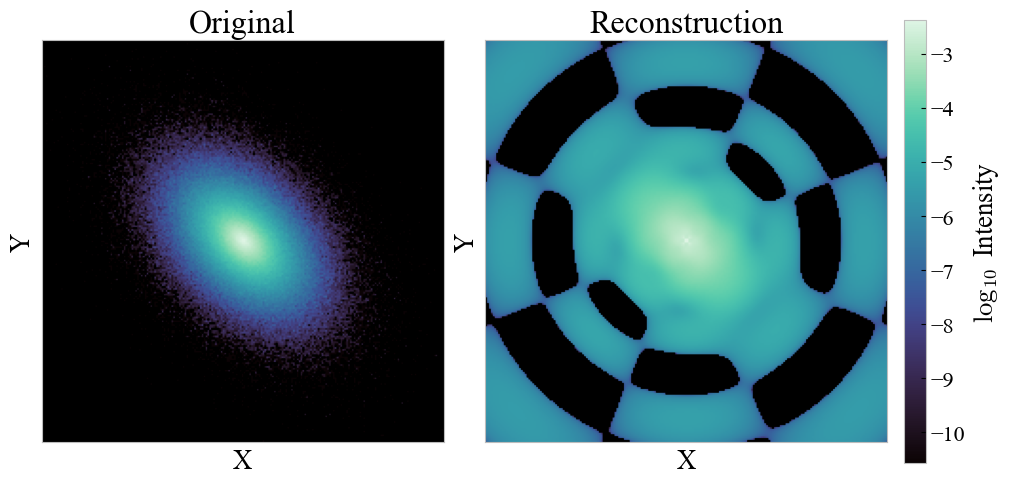

In [10]:
"""Creating side-by-side plots of an arbitrary disc galaxy and reconstruction"""

rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 6, 10 #Change to realise the effect of varying modes
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
# Generate galaxy, mass normalized
N=1000000
a=10
D = DiscGalaxy(N=N, a=a)
D.rotate_disc(50, 0, 90+45)   # inc=50, PA=45 as example
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()


#FLEX expansion and reconstruction
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p) 

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = X2.ravel()
y_flat = Y2.ravel()
w_flat = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)

# avoid divide-by-zero; normalize total flux to the original image
recon_img = recon_img / np.maximum(counts, 1)
# match total intensity
total_recon = np.sum(recon_img)
if total_recon > 0:
    recon_img *= np.sum(img_orig) / total_recon

recon_img = recon_img.T  # to match imshow orientation


# Plotting side-by-side
cmap = sns.color_palette("mako", as_cmap=True)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for ax, im, title in zip(axes, [orig_log, recon_log], ["Original", "Reconstruction"]):
    h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
    ax.set_title(title)
    ax.set(facecolor = "black")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar = fig.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label(r"$\log_{10}$ Intensity")


plt.show()


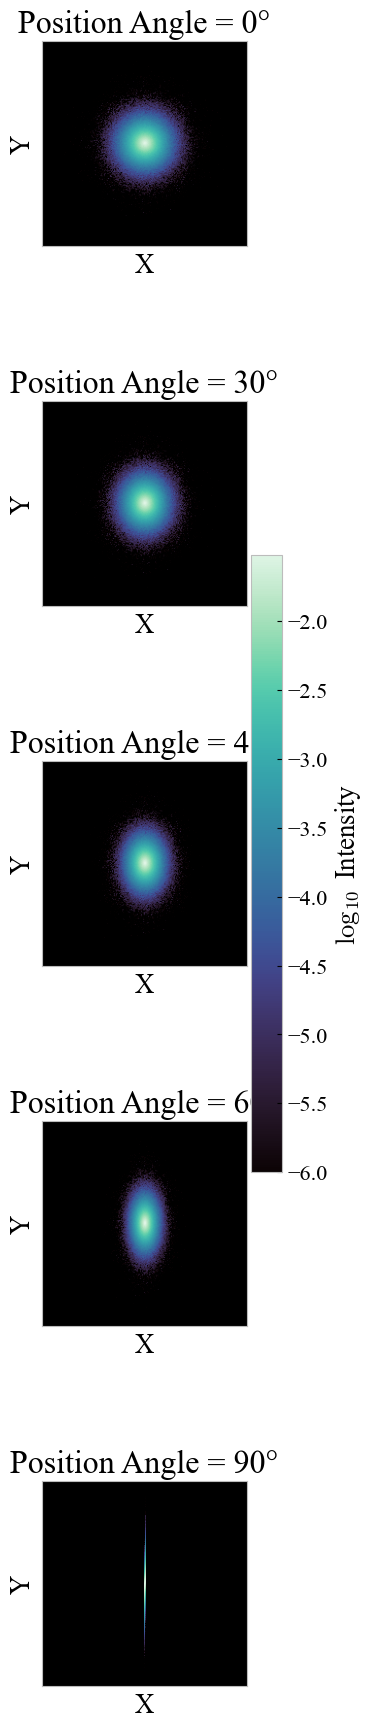

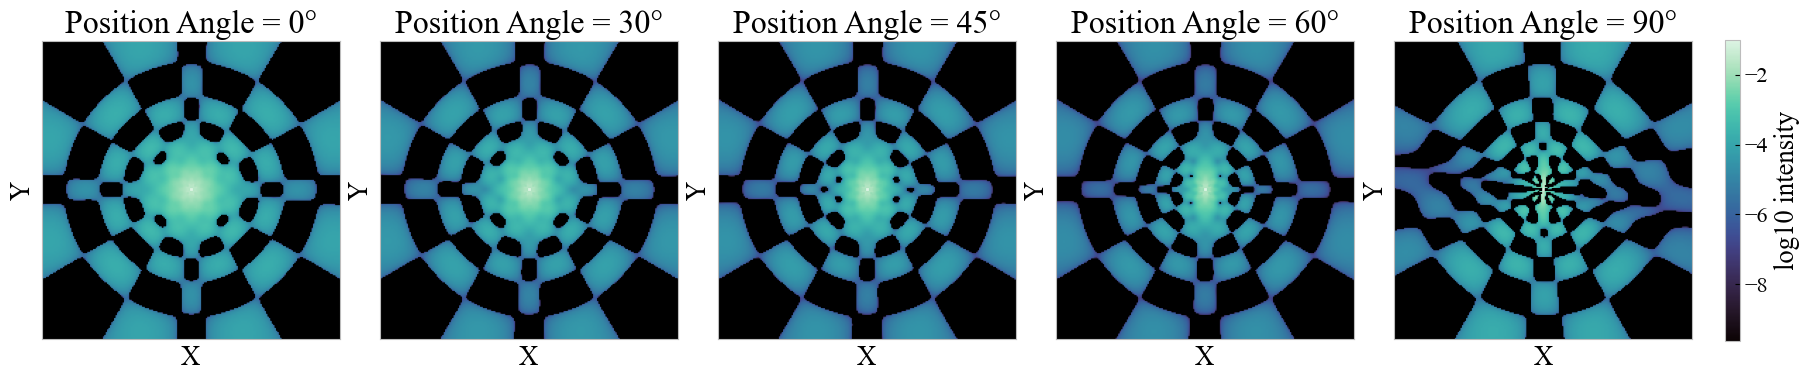

In [ ]:
N = 1000000
a = 6                    # reconstruction scale as desired
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 10, 10 #max modes for expansion/reconstruction
incs = [0, 30, 45, 60, 90]
PAs= [0, 20,40,60,80,90]  # Position angles in degrees

# precompute grid edges/centers + extent
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

orig_imgs = []
recon_imgs = []
#Vary inclination, fixed PA
for inc in incs:
    # Generate galaxy, mass normalized
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 90)   # vary inc, fixed PA=0
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    orig_imgs.append(img_orig)

    #FLEX expansion and reconstruction
    E1 = D.make_expansion(mmax, nmax, a, noisy=False)
    E1.laguerre_reconstruction(D.r, D.p)  

    # Map reconstruction back to the image grid via histogramming
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    x_flat = X2.ravel()
    y_flat = Y2.ravel()
    w_flat = E1.reconstruction.ravel()

    recon_img, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges],
        weights=w_flat
    )
    counts, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges]
    )

    # avoid divide-by-zero; normalize total flux to the original image
    recon_img = recon_img / np.maximum(counts, 1)
    # match total intensity
    total_recon = np.sum(recon_img)
    if total_recon > 0:
        recon_img *= np.sum(img_orig) / total_recon

    recon_img = recon_img.T  # to match imshow orientation
    recon_imgs.append(recon_img)

cmap=sns.color_palette("mako", as_cmap=True)
# Plotting

fig1, axes1 = plt.subplots(len(incs),1,  figsize=(3.6, 3.6*len(incs)), constrained_layout=True)
for ax in axes1:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes1 = [axes1]
for ax, inc, im in zip(axes1, incs, orig_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar1 = fig1.colorbar(h, ax=axes1, shrink=0.9, pad=0.02)
cbar1.set_label(r"$\log_{10}$ Intensity")
    
plt.show()

fig2, axes2 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes2:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes2 = [axes2]
for ax, inc, im in zip(axes2, incs, recon_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data.T, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")


cbar2 = fig2.colorbar(h, ax=axes2, shrink=0.9, pad=0.02)
cbar2.set_label("log10 intensity")

plt.show()

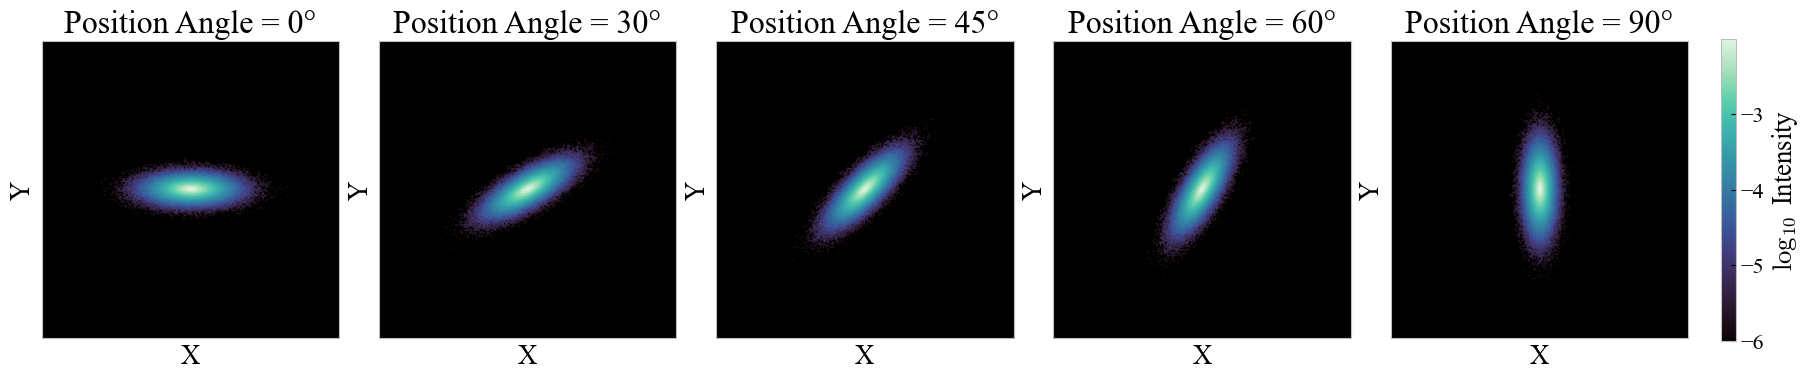

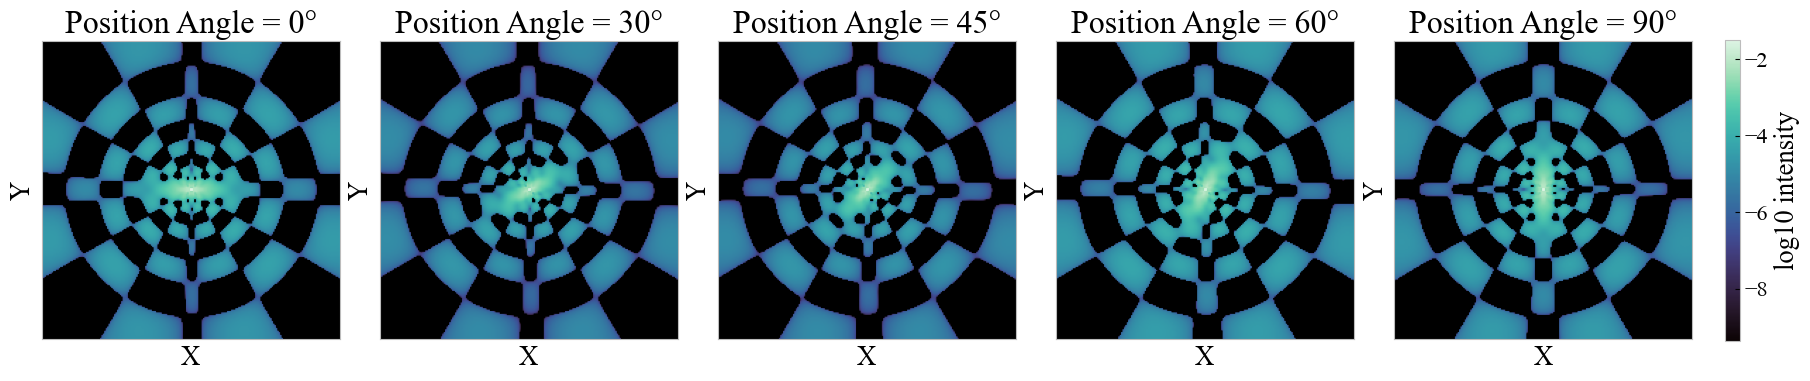

In [32]:
N = 1000000
a = 6                    # reconstruction scale as desired
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 10, 10 #max modes for expansion/reconstruction
incs = [0, 30, 45, 60, 90]
PAs= [0, 20,40,60,80,90]  # Position angles in degrees

# precompute grid edges/centers + extent
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

orig_imgs = []
recon_imgs = []
#Vary inclination, fixed PA
for inc in incs:
    # Generate galaxy, mass normalized
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(70, 0, inc)   # vary inc, fixed PA=0
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    orig_imgs.append(img_orig)

    #FLEX expansion and reconstruction
    E1 = D.make_expansion(mmax, nmax, a, noisy=False)
    E1.laguerre_reconstruction(D.r, D.p)  

    # Map reconstruction back to the image grid via histogramming
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    x_flat = X2.ravel()
    y_flat = Y2.ravel()
    w_flat = E1.reconstruction.ravel()

    recon_img, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges],
        weights=w_flat
    )
    counts, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges]
    )

    # avoid divide-by-zero; normalize total flux to the original image
    recon_img = recon_img / np.maximum(counts, 1)
    # match total intensity
    total_recon = np.sum(recon_img)
    if total_recon > 0:
        recon_img *= np.sum(img_orig) / total_recon

    recon_img = recon_img.T  # to match imshow orientation
    recon_imgs.append(recon_img)

cmap=sns.color_palette("mako", as_cmap=True)
# Plotting

fig1, axes1 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes1:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes1 = [axes1]
for ax, inc, im in zip(axes1, incs, orig_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar1 = fig1.colorbar(h, ax=axes1, shrink=0.9, pad=0.02)
cbar1.set_label(r"$\log_{10}$ Intensity")
    
plt.show()
# plot FLEX reconstructions
fig2, axes2 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes2:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes2 = [axes2]
for ax, inc, im in zip(axes2, incs, recon_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data.T, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")


cbar2 = fig2.colorbar(h, ax=axes2, shrink=0.9, pad=0.02)
cbar2.set_label("log10 intensity")

plt.show()